# Code Preprosessing With WEIGHTS

# ANALISIS KOMPARATIF KINERJA ALGORITMA MULTI-LAYER PERCEPTRON (MLP) DAN CONVOLUTION NEURAL NETWORK (CNN) DENGAN EKSTRAKSI FITUR LANDMARK MEDIAPIPE UNTUK PENGENALAN BAHASA ISYARAT INDONESIA

In [3]:
import os
import random
import numpy as np
import tensorflow as tf

def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    # os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # optional

set_all_seeds(42)

# Import Library

In [4]:
# ===============================================
# Import Library
# ===============================================
import os
import cv2
import numpy as np
import pandas as pd
import mediapipe as mp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
import seaborn as sns
import sys
import random

print(sys.version)
print("TensorFlow:", tf.__version__)
print("MediaPipe:", mp.__version__)

3.10.19 (main, Oct 10 2025, 08:52:10) [GCC 13.3.0]
TensorFlow: 2.15.0
MediaPipe: 0.10.14


# Load Dataset

Kategori: A, Jumlah File: 220
Kategori: B, Jumlah File: 220
Kategori: C, Jumlah File: 220
Kategori: D, Jumlah File: 220
Kategori: E, Jumlah File: 220
Kategori: F, Jumlah File: 220
Kategori: G, Jumlah File: 220
Kategori: H, Jumlah File: 220
Kategori: I, Jumlah File: 220
Kategori: K, Jumlah File: 220
Kategori: L, Jumlah File: 220
Kategori: M, Jumlah File: 220
Kategori: N, Jumlah File: 220
Kategori: O, Jumlah File: 220
Kategori: P, Jumlah File: 220
Kategori: Q, Jumlah File: 220
Kategori: R, Jumlah File: 220
Kategori: S, Jumlah File: 220
Kategori: T, Jumlah File: 220
Kategori: U, Jumlah File: 220
Kategori: V, Jumlah File: 220
Kategori: W, Jumlah File: 220
Kategori: X, Jumlah File: 207
Kategori: Y, Jumlah File: 220
Total Gambar: 5267

Kategori: A - 5 Gambar Acak:


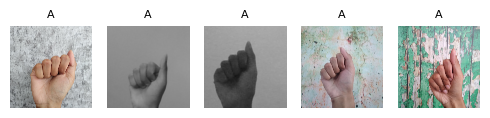


Kategori: B - 5 Gambar Acak:


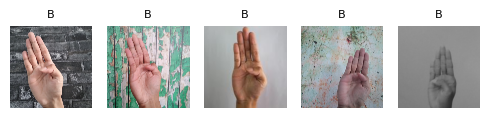


Kategori: C - 5 Gambar Acak:


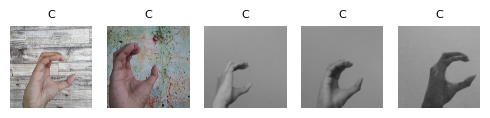


Kategori: D - 5 Gambar Acak:


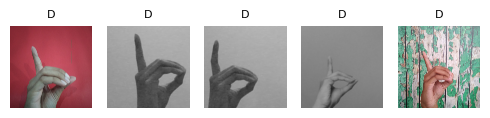


Kategori: E - 5 Gambar Acak:


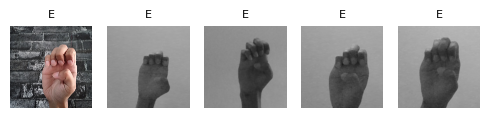


Kategori: F - 5 Gambar Acak:


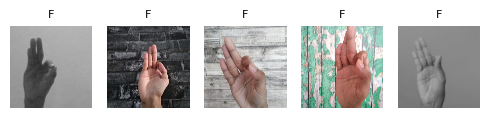


Kategori: G - 5 Gambar Acak:


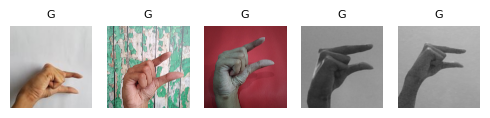


Kategori: H - 5 Gambar Acak:


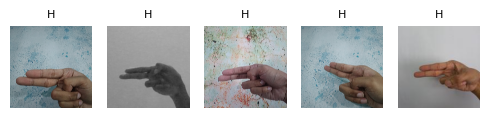


Kategori: I - 5 Gambar Acak:


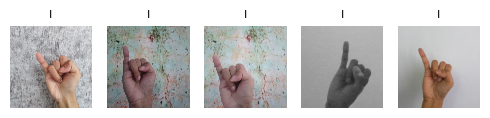


Kategori: K - 5 Gambar Acak:


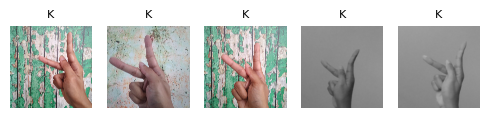


Kategori: L - 5 Gambar Acak:


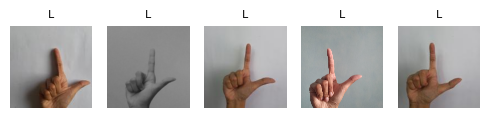


Kategori: M - 5 Gambar Acak:


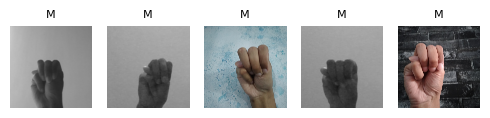


Kategori: N - 5 Gambar Acak:


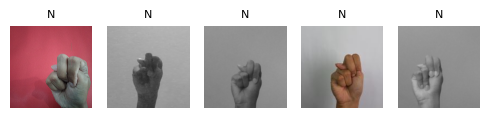


Kategori: O - 5 Gambar Acak:


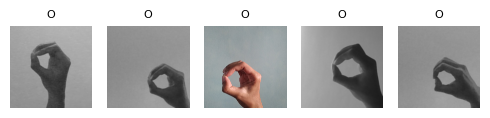


Kategori: P - 5 Gambar Acak:


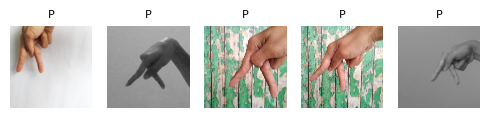


Kategori: Q - 5 Gambar Acak:


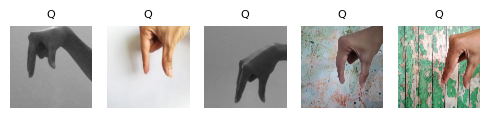


Kategori: R - 5 Gambar Acak:


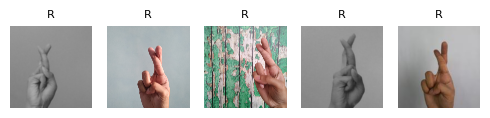


Kategori: S - 5 Gambar Acak:


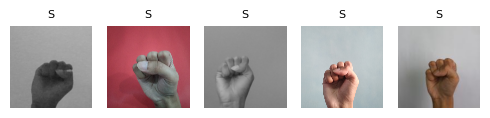


Kategori: T - 5 Gambar Acak:


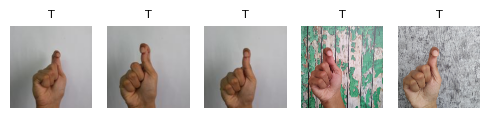


Kategori: U - 5 Gambar Acak:


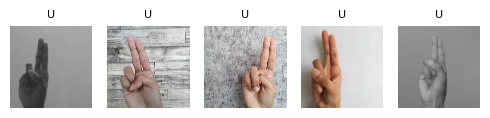


Kategori: V - 5 Gambar Acak:


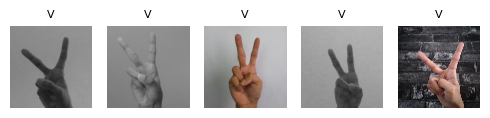


Kategori: W - 5 Gambar Acak:


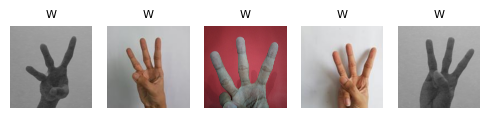


Kategori: X - 5 Gambar Acak:


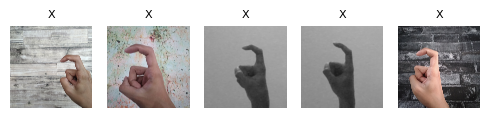


Kategori: Y - 5 Gambar Acak:


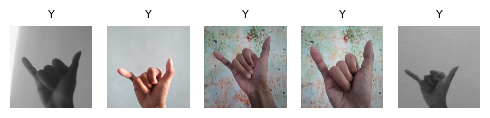

In [5]:
# ===============================================
# Load Dataset (path gambar per kelas, handle split bawaan)
# ===============================================
DATASET_DIR = r"/media/ekhsan/New Volume/ME/CODE/Landmark_mediapipe/Dataset/SIBI"  
# Hitung jumlah gambar per kategori
data = {}
for category in sorted(os.listdir(DATASET_DIR)):
    category_path = os.path.join(DATASET_DIR, category)
    if os.path.isdir(category_path):
        files = [f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        data[category] = files

# Print jumlah gambar
for category, files in data.items():
    print(f"Kategori: {category}, Jumlah File: {len(files)}")
total_images = sum(len(files) for files in data.values())
print(f"Total Gambar: {total_images}")

# Menampilkan 5 gambar random per kategori 
for category, files in data.items():
    print(f"\nKategori: {category} - 5 Gambar Acak:")
    plt.figure(figsize=(5, 3))
    selected_files = random.sample(files, min(5, len(files)))
    for i, file in enumerate(selected_files):
        file_path = os.path.join(DATASET_DIR, category, file)
        img = cv2.imread(file_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, 5, i + 1)
            plt.imshow(img)
            plt.title(f"{category}", fontsize=8)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Ekstraksi Fitur

I0000 00:00:1770791591.342212   67255 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1770791591.453920   68611 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.288.01), renderer: NVIDIA GeForce GTX 960M/PCIe/SSE2
Processing A:   0%|          | 0/220 [00:00<?, ?it/s]INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1770791592.081890   68604 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1770791592.117907   68610 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Processing A:   7%|▋         | 16/220 [00:01<00:09, 21.00it/s]/media/ekhsan/New Volume/ME/CODE/Landmark_mediapipe/mevenv/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_

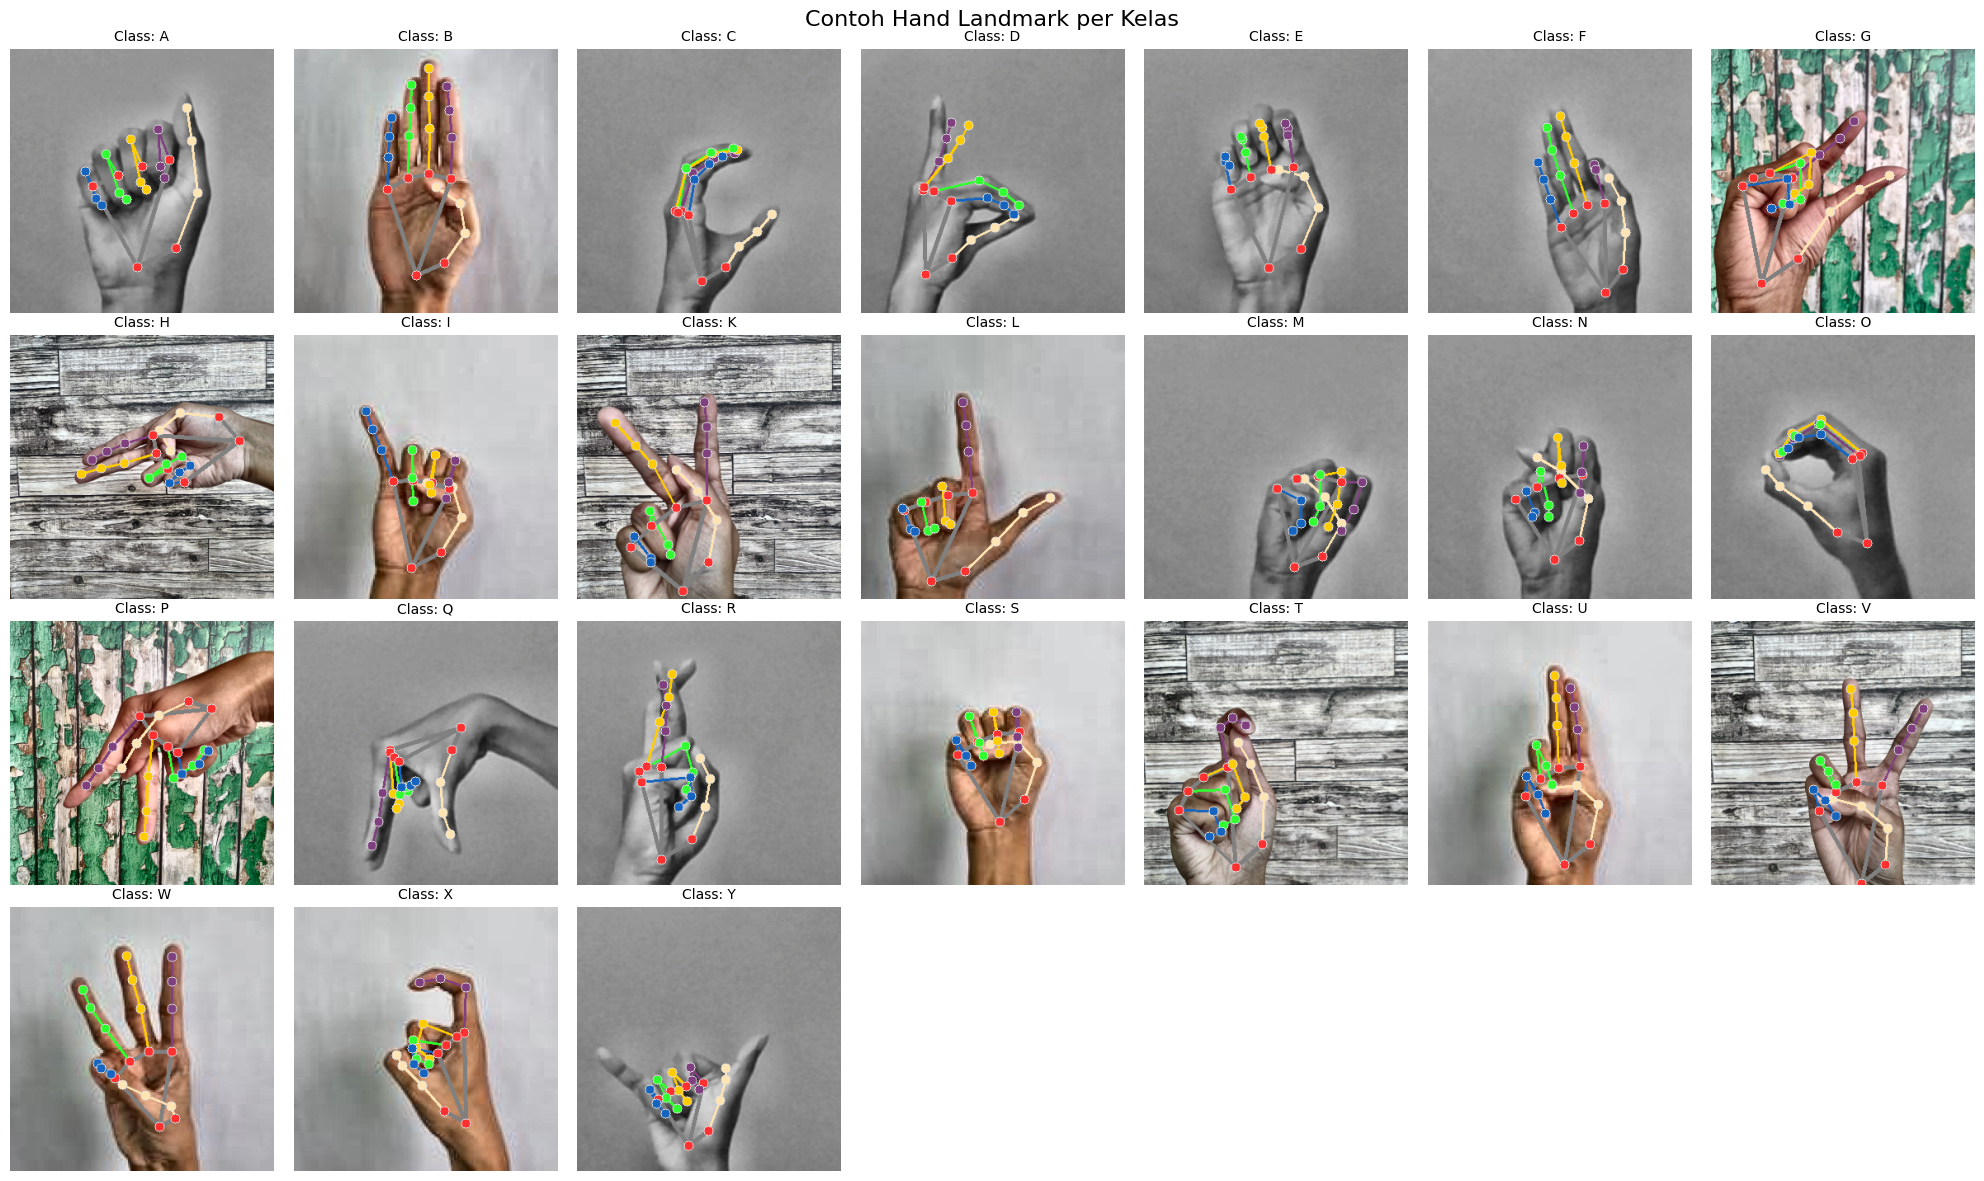


Total samples: 1490
Classes found: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S'
 'T' 'U' 'V' 'W' 'X' 'Y']

Hand type distribution:
hand_type
Left     1486
Right       4
Name: count, dtype: int64

Features saved to 'landmark_data.csv'


In [ ]:
import cv2
import mediapipe as mp
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# ------------------------------------------------
# 3. Ekstraksi Fitur Landmark Mediapipe
# ------------------------------------------------

# Preprocessing
def preprocess_image(img, target_size=320):
    # Konversi ke RGB   
    if img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
    elif img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w = img.shape[:2]
    scale = target_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Padding (letterbox)
    pad_w = target_size - new_w
    pad_h = target_size - new_h
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left
    padded = cv2.copyMakeBorder(
        resized, top, bottom, left, right,
        cv2.BORDER_CONSTANT, value=[0, 0, 0]
    )

    # CLAHE pada channel luminance (LAB)
    lab = cv2.cvtColor(padded, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    return enhanced

# MediaPipe setup
mp_hands = mp.solutions.hands # type: ignore
mp_drawing = mp.solutions.drawing_utils # type: ignore
mp_drawing_styles = mp.solutions.drawing_styles # type: ignore

# Ekstraksi fitur
features = []
visualization = {}

with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    model_complexity=1,
    min_detection_confidence=0.75,
    min_tracking_confidence=0.75
) as hands:

    for label in sorted(os.listdir(DATASET_DIR)):
        folder = os.path.join(DATASET_DIR, label)
        if not os.path.isdir(folder):
            continue

        images = [f for f in os.listdir(folder)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        for img_file in tqdm(images, desc=f"Processing {label}"):
            img_path = os.path.join(folder, img_file)

            img = cv2.imread(img_path)
            if img is None:
                continue

            rgb = preprocess_image(img)

            results = hands.process(rgb)

            if results.multi_hand_landmarks and results.multi_handedness:
                for hand_landmarks, handedness in zip(
                        results.multi_hand_landmarks,
                        results.multi_handedness):

                    score = handedness.classification[0].score
                    hand_label = handedness.classification[0].label

                    if score > 0.7:
                          # WRIST NORMALIZATION 
                        wrist = hand_landmarks.landmark[mp_hands.HandLandmark.WRIST]
                        row = []

                        for lm in hand_landmarks.landmark:
                            x = lm.x - wrist.x
                            y = lm.y - wrist.y
                            z = lm.z - wrist.z

                            # ORIENTATION CANONICALIZATION
                            if hand_label == 'Left':
                                x = -x  # horizontal mirroring

                            row.extend([x, y, z])
                       
                        row.append(label)
                        row.append(hand_label)
                        row.append(img_file)
                        features.append(row)

                        if label not in visualization:
                            img_copy = cv2.cvtColor(rgb.copy(), cv2.COLOR_RGB2BGR)
                            mp_drawing.draw_landmarks(
                                img_copy,
                                hand_landmarks,
                                mp_hands.HAND_CONNECTIONS,
                                mp_drawing_styles.get_default_hand_landmarks_style(),
                                mp_drawing_styles.get_default_hand_connections_style()
                            )
                            visualization[label] = cv2.cvtColor(
                                img_copy, cv2.COLOR_BGR2RGB
                            )

# ------------------------------------------------
# Visualisasi landmark
# ------------------------------------------------
if visualization:
    cols = 7
    rows = (len(visualization) + cols - 1) // cols
    plt.figure(figsize=(20, 3 * rows))

    for i, (label, img) in enumerate(visualization.items()):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(f'Class: {label}', fontsize=10)
        plt.axis('off')

    plt.suptitle("Contoh Hand Landmark per Kelas", fontsize=16)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------
# Simpan ke CSV
# ------------------------------------------------
if features:
    columns = (
        [f"{axis}{i}" for i in range(21) for axis in ['x', 'y', 'z']]
        + ['label', 'hand_type', 'source_file']
    )

    features_df = pd.DataFrame(features, columns=columns)

    print(f"\nTotal samples: {len(features_df)}")
    print(f"Classes found: {features_df['label'].unique()}")
    print("\nHand type distribution:")
    print(features_df['hand_type'].value_counts())

    features_df.to_csv("landmark_data.csv", index=False)
    print("\nFeatures saved to 'landmark_data.csv'")
else:
    print("Tidak ada fitur yang berhasil diekstraksi")

# Load Data landmark CSV

Classes: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S'
 'T' 'U' 'V' 'W' 'X' 'Y']
Encoded labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]

Total data: 1490


/tmp/ipykernel_67255/1723011916.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


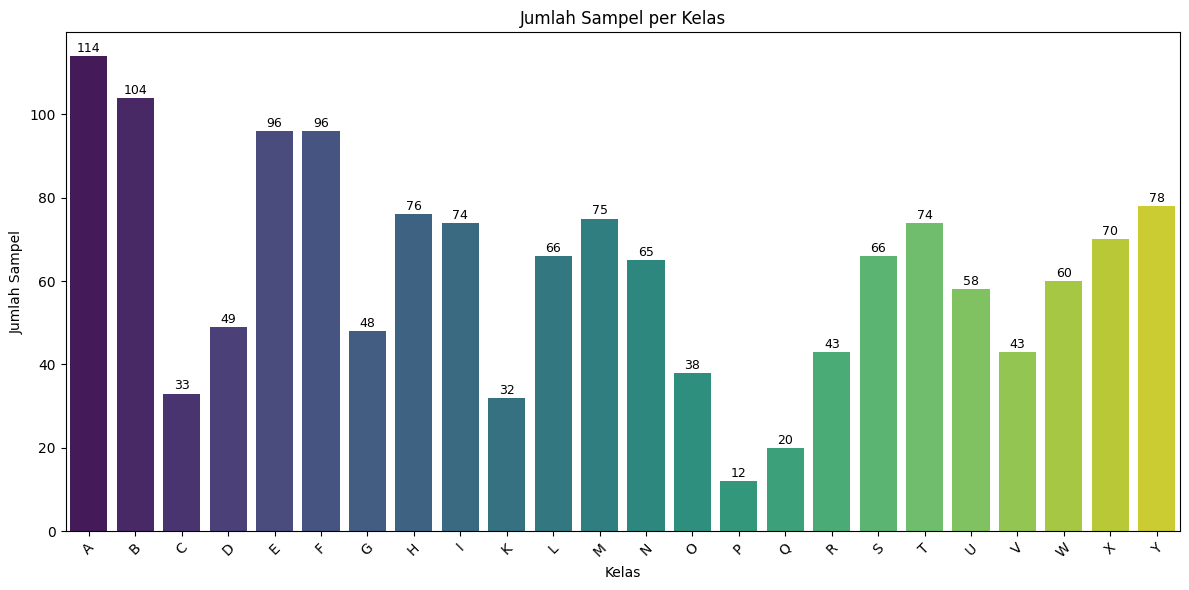

In [7]:
# ===============================================
# 1. LOAD DATA & EKSPLORASI DATASET
# ===============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Load dataset CSV
df = pd.read_csv("landmark_data.csv")

# Ambil fitur landmark (x0–x20, y0–y20, z0–z20)
feature_cols = [f"{axis}{i}" for axis in ['x', 'y', 'z'] for i in range(21)]
X = df[feature_cols].values
y = df['label'].values

# Encode label
le = LabelEncoder()
y_encoded = le.fit_transform(y) # type: ignore

print("Classes:", le.classes_)
print("Encoded labels:", np.unique(y_encoded))

# Jumlah total data
total_data = len(df)
print(f"\nTotal data: {total_data}")

# =====================================================
# Visualisasi jumlah sampel per kelas
# =====================================================
class_counts = df['label'].value_counts().reindex(le.classes_)

plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")

plt.title("Jumlah Sampel per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Sampel")

for i, v in enumerate(class_counts.values):
    plt.text(i, v + 1, str(v), ha='center', fontsize=9)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Split Data Train & Test

In [8]:
# ===============================================
# 2. SPLIT DATA TRAIN - TEST
# ===============================================

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

print(f"\nTrain samples: {len(X_train)}")
print(f"Test samples : {len(X_test)}")

# Distribusi kelas pada data training dan testing
train_class_counts = pd.Series(y_train).value_counts().sort_index()
test_class_counts = pd.Series(y_test).value_counts().sort_index()

print("\nDistribusi kelas pada data TRAIN:")
print(train_class_counts)

print("\nDistribusi kelas pada data TEST:")
print(test_class_counts)

print("\nPersentase data train:", len(X_train) / len(X) * 100, "%")
print("Persentase data test :", len(X_test) / len(X) * 100, "%")



Train samples: 1192
Test samples : 298

Distribusi kelas pada data TRAIN:
0     91
1     83
2     26
3     39
4     77
5     77
6     39
7     61
8     59
9     26
10    53
11    60
12    52
13    30
14    10
15    16
16    34
17    53
18    59
19    46
20    34
21    48
22    56
23    63
Name: count, dtype: int64

Distribusi kelas pada data TEST:
0     23
1     21
2      7
3     10
4     19
5     19
6      9
7     15
8     15
9      6
10    13
11    15
12    13
13     8
14     2
15     4
16     9
17    13
18    15
19    12
20     9
21    12
22    14
23    15
Name: count, dtype: int64

Persentase data train: 80.0 %
Persentase data test : 20.0 %


# Pre-Processing Data Landmark (CSV)


Distribusi Scale Landmark [9] — BEFORE Scale Normalization


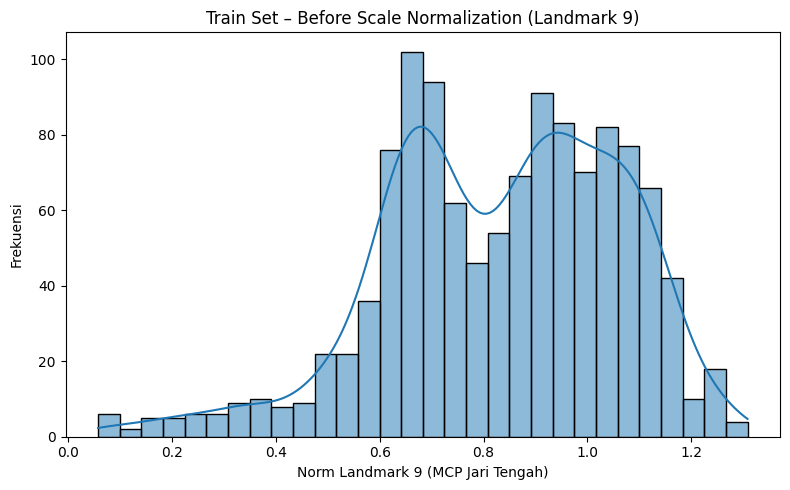

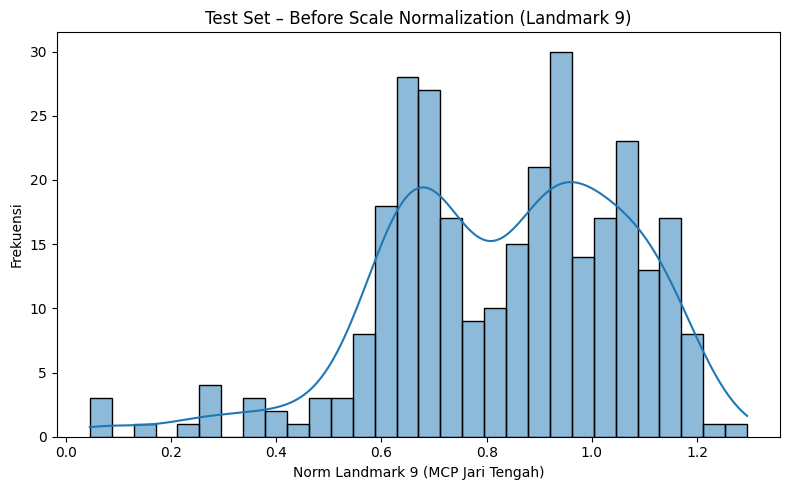


Distribusi Scale Landmark [9] — AFTER Scale Normalization


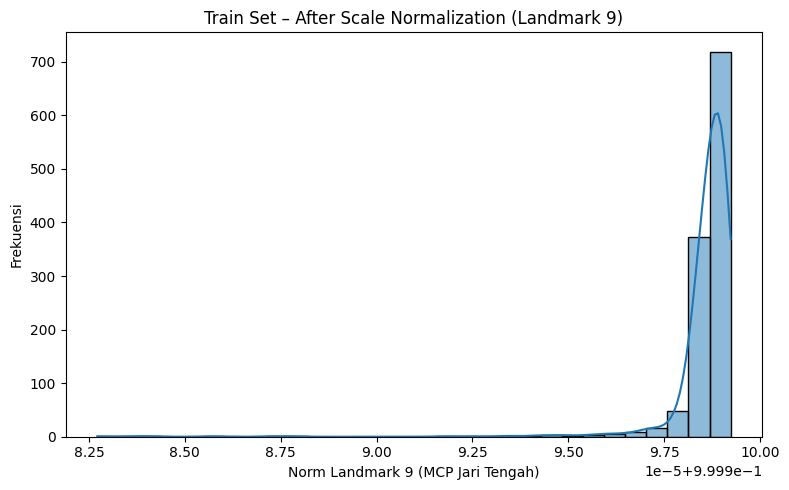

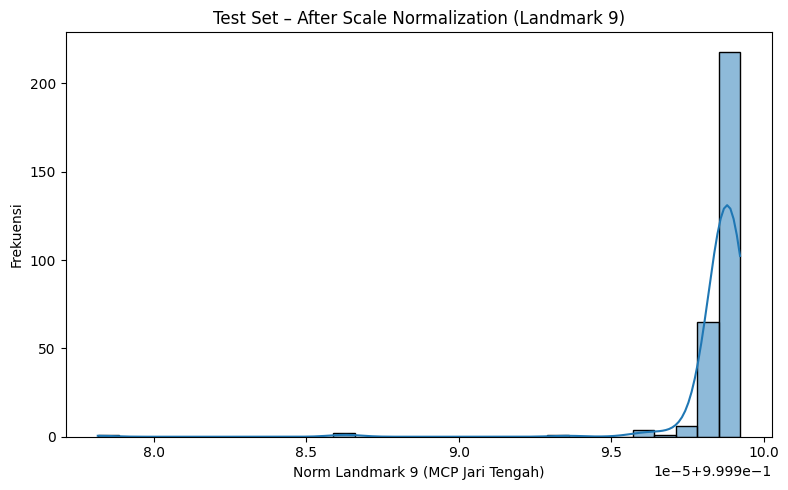

In [9]:
# Scale Normalization landmark[9] MCP

# Simpan data sebelum scale normalization landmark [9]
X_train_before_scale = X_train.copy()
X_test_before_scale  = X_test.copy()


# SCALE NORMALIZATION LANDMARK JARI TENGAH [9]
def normalize_landmark_by_mcp9(X):
    Xn = X.copy()
    lm9 = Xn[:, 27:30]
    scale = np.linalg.norm(lm9, axis=1, keepdims=True) + 1e-6
    return Xn / scale

X_train = normalize_landmark_by_mcp9(X_train)
X_test  = normalize_landmark_by_mcp9(X_test)

# VISUALISASI DISTRIBUSI SCALE LANDMARK [9]
def visualize_scale_landmark9(X, title):
    lm9 = X[:, 27:30]
    scales = np.linalg.norm(lm9, axis=1)

    plt.figure(figsize=(8, 5))
    sns.histplot(scales, bins=30, kde=True)
    plt.title(title)
    plt.xlabel("Norm Landmark 9 (MCP Jari Tengah)")
    plt.ylabel("Frekuensi")
    plt.tight_layout()
    plt.show()

print("\nDistribusi Scale Landmark [9] — BEFORE Scale Normalization")
visualize_scale_landmark9(
    X_train_before_scale,
    "Train Set – Before Scale Normalization (Landmark 9)"
)
visualize_scale_landmark9(
    X_test_before_scale,
    "Test Set – Before Scale Normalization (Landmark 9)"
)

print("\nDistribusi Scale Landmark [9] — AFTER Scale Normalization")
visualize_scale_landmark9(
    X_train,
    "Train Set – After Scale Normalization (Landmark 9)"
)
visualize_scale_landmark9(
    X_test,
    "Test Set – After Scale Normalization (Landmark 9)"
)


Menerapkan augmentasi landmark ke data train
Ukuran data train setelah augmentasi: 3576 sampel (asli: 1192)


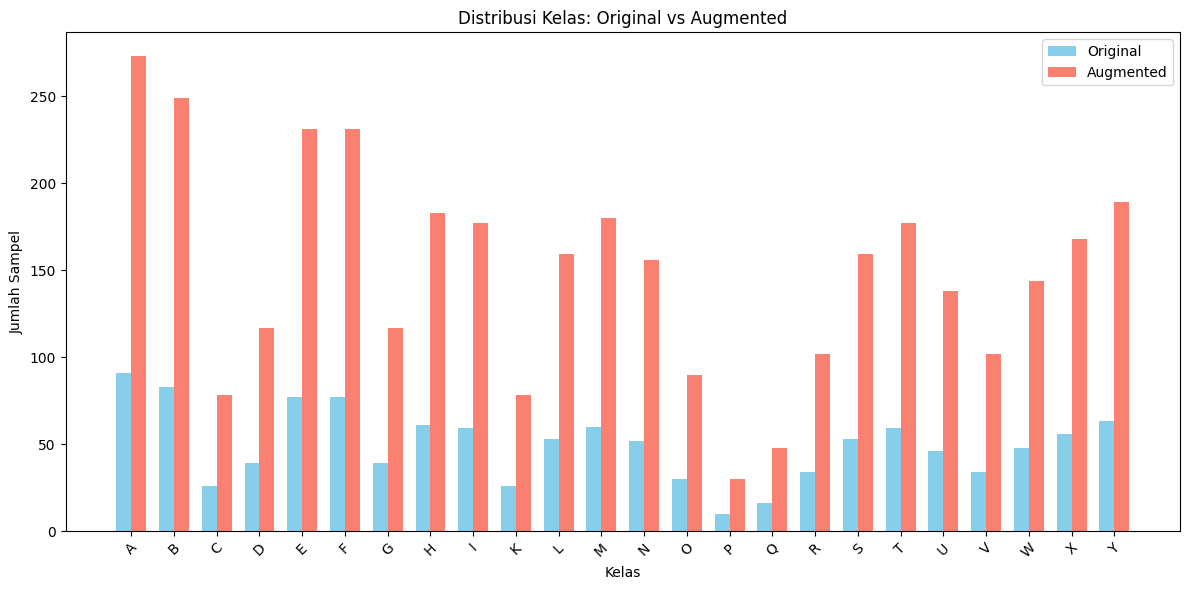

In [10]:
# ===============================================
# Fungsi Augmentasi dengan Seed Control
# ===============================================
def augment_landmarks(X, prob=0.8, seed=None):
    if seed is not None:
        np.random.seed(seed) 
    
    if np.random.random() > prob:
        return X.copy()
    
    X_aug = X.copy().astype(np.float32)
    
    #Gaussian noise
    noise_level = 0.012
    X_aug += np.random.normal(0, noise_level, X.shape)
    
    # Random scaling global
    scale = np.random.uniform(0.92, 1.08)
    X_aug *= scale
    
    # Rotasi kecil di bidang XY
    if np.random.random() > 0.4:
        angle_deg = np.random.uniform(-8, 8)
        angle_rad = np.deg2rad(angle_deg)
        cos_a = np.cos(angle_rad)
        sin_a = np.sin(angle_rad)
        
        rot_matrix = np.array([
            [cos_a, -sin_a, 0],
            [sin_a, cos_a, 0],
            [0, 0, 1]
        ])
        
        for i in range(21):
            start = i * 3
            end = start + 3
            point = X_aug[:, start:end]
            X_aug[:, start:end] = np.dot(point, rot_matrix.T)
    
    return X_aug

print("\nMenerapkan augmentasi landmark ke data train")
num_augmentations = 2  # 3x lipat (asli + 2 augmentasi)

augmented_versions = []
for i in range(num_augmentations):
    aug_seed = 42 + (i + 1) * 10
    X_aug = augment_landmarks(X_train, prob=0.8, seed=aug_seed)
    augmented_versions.append(X_aug)

# Gabung data asli + semua augmentasi
X_train_aug = np.vstack([X_train] + augmented_versions)
y_train_aug = np.concatenate([y_train] * (1 + num_augmentations))

print(f"Ukuran data train setelah augmentasi: {X_train_aug.shape[0]} sampel "
      f"(asli: {len(X_train)})")

# visualisasi distribusi sebelum dan sesudah augmentasi
def visualize_class_distribution(y_original, y_augmented, class_names):
    original_counts = pd.Series(y_original).value_counts().sort_index()
    augmented_counts = pd.Series(y_augmented).value_counts().sort_index()

    x = np.arange(len(class_names))
    width = 0.35

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, original_counts.values, width, label='Original', color='skyblue')
    plt.bar(x + width/2, augmented_counts.values, width, label='Augmented', color='salmon')

    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Sampel')
    plt.title('Distribusi Kelas: Original vs Augmented')
    plt.xticks(x, class_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
visualize_class_distribution(
    y_train,
    y_train_aug,
    le.classes_
)   

# Update variabel yang akan dipakai training
X_train = X_train_aug
y_train = y_train_aug       

# Class Weights Modeling

In [11]:
# ===============================================
# 6. HITUNG CLASS WEIGHTS UNTUK MODELING
# ===============================================

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))
print("Class weights:")
for cls, weight in class_weight_dict.items():
    print(f"Class {cls}: {weight:.4f}")

Class weights:
Class 0: 0.5458
Class 1: 0.5984
Class 2: 1.9103
Class 3: 1.2735
Class 4: 0.6450
Class 5: 0.6450
Class 6: 1.2735
Class 7: 0.8142
Class 8: 0.8418
Class 9: 1.9103
Class 10: 0.9371
Class 11: 0.8278
Class 12: 0.9551
Class 13: 1.6556
Class 14: 4.9667
Class 15: 3.1042
Class 16: 1.4608
Class 17: 0.9371
Class 18: 0.8418
Class 19: 1.0797
Class 20: 1.4608
Class 21: 1.0347
Class 22: 0.8869
Class 23: 0.7884


# one-hot encode

In [12]:
# one-hot encode label untuk model Keras
num_classes = len(le.classes_)
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)
print(f"\nNumber of classes: {num_classes}")

# vector label sample setiap kelas dan label asli sesuai urutan label
print("\nContoh one-hot encoding per kelas:")
for cls in range(num_classes):
    idx = np.where(y_train == cls)[0][0]
    print(f"Class {cls} ({le.inverse_transform([cls])[0]}): {y_train_cat[idx]}")



Number of classes: 24

Contoh one-hot encoding per kelas:
Class 0 (A): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Class 1 (B): [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Class 2 (C): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Class 3 (D): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Class 4 (E): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Class 5 (F): [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Class 6 (G): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Class 7 (H): [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Class 8 (I): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Class 9 (K): [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Class 10 (L): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.

# Training MLP


MLP MODEL SUMMARY
Model: "MLP_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_256 (Dense)           (None, 256)               16384     
                                                                 
 Dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Dense_128 (Dense)           (None, 128)               32896     
                                                                 
 Dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 Output (Dense)              (None, 24)                3096      
                                                                 
Total params: 52376 (204.59 KB)
Trainable params: 52376 (204.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


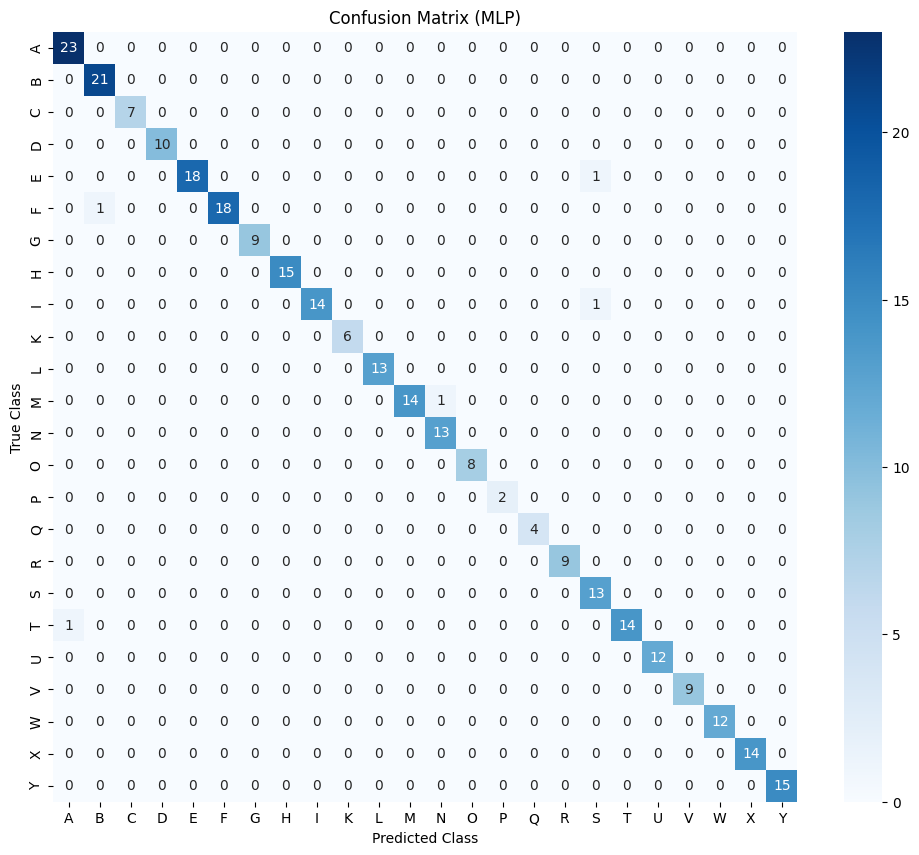

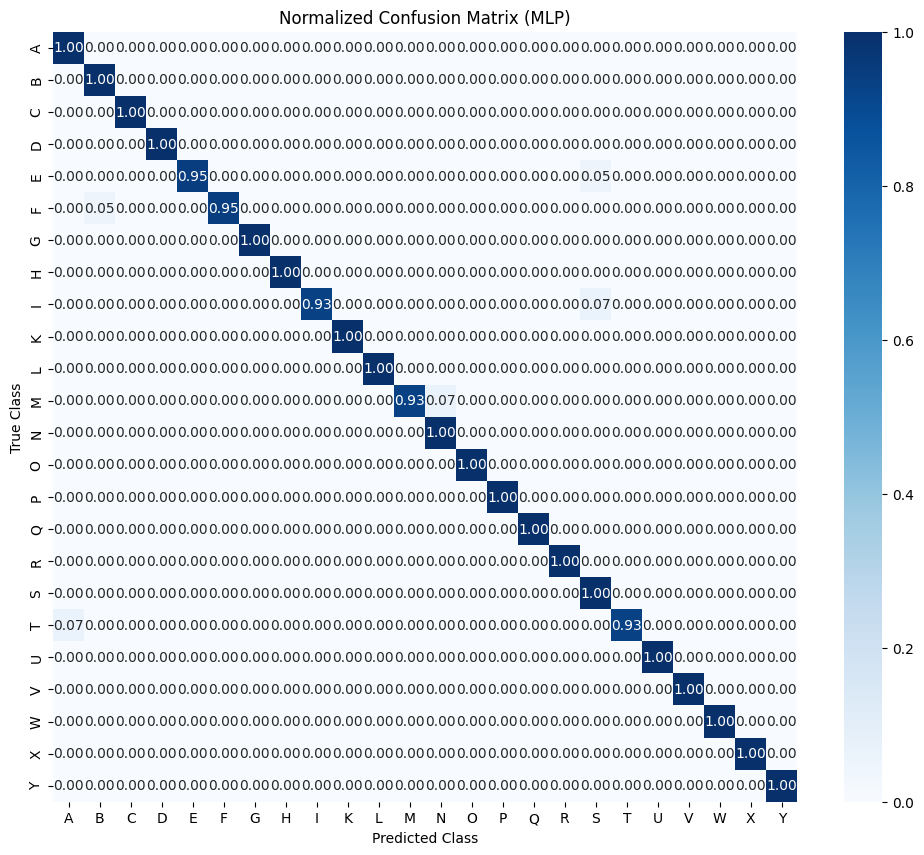

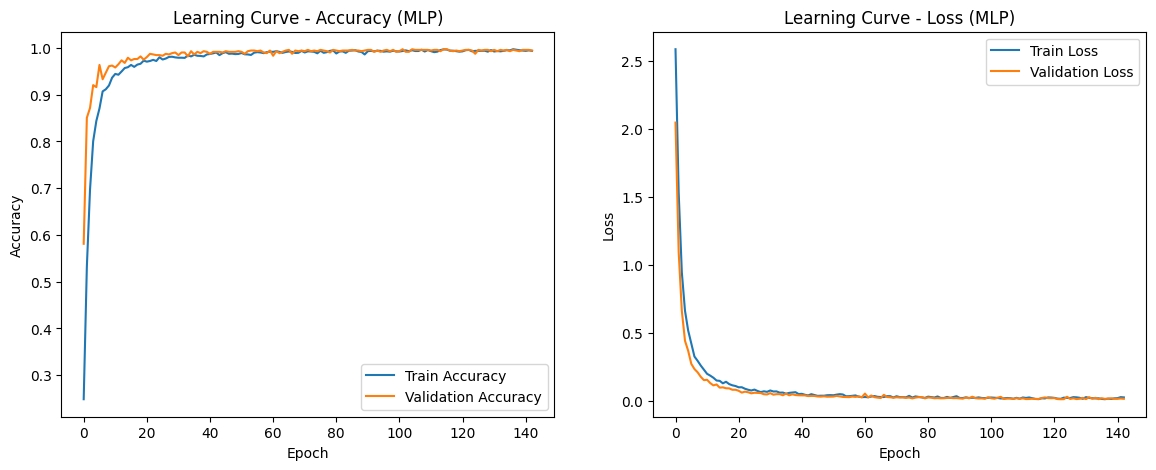


START 10-Fold CROSS VALIDATION (MLP)
Fold 1 Validation Accuracy: 0.9972
Fold 2 Validation Accuracy: 1.0000
Fold 3 Validation Accuracy: 0.9944
Fold 4 Validation Accuracy: 0.9972
Fold 5 Validation Accuracy: 1.0000
Fold 6 Validation Accuracy: 0.9888
Fold 7 Validation Accuracy: 1.0000
Fold 8 Validation Accuracy: 1.0000
Fold 9 Validation Accuracy: 0.9944
Fold 10 Validation Accuracy: 1.0000
10-Fold CV Accuracy (MLP): 0.9972 ± 0.0035
10/10 [==============================] - 0s 1ms/step


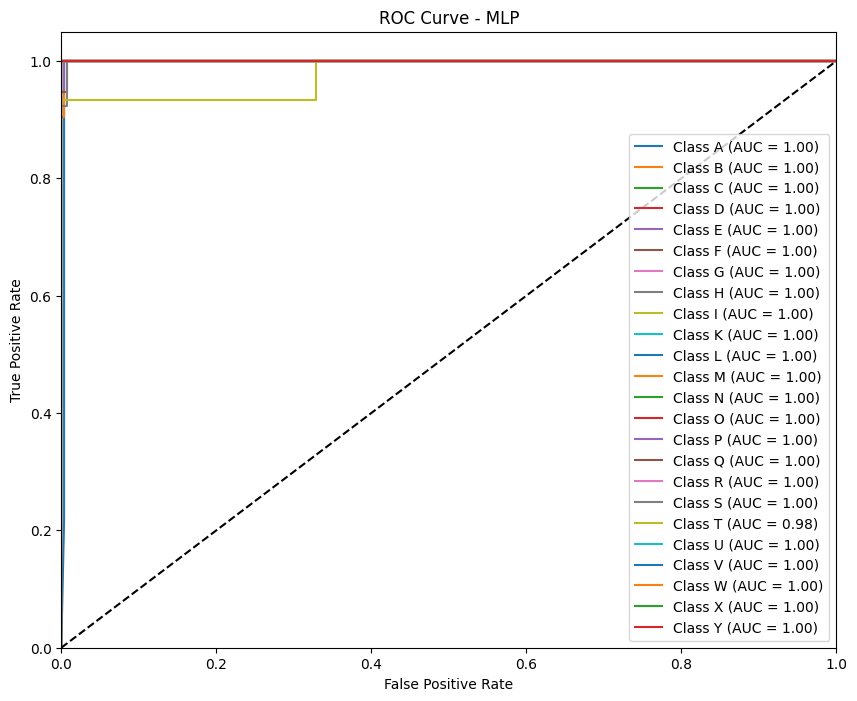

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Dropout # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
import time


# =========================
# 1. DEFINE MLP MODEL
# =========================
mlp = Sequential(name="MLP_Model")
mlp.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],), name="Dense_256"))
mlp.add(Dropout(0.3, name="Dropout_1"))
mlp.add(Dense(128, activation='relu', name="Dense_128"))
mlp.add(Dropout(0.3, name="Dropout_2"))
mlp.add(Dense(num_classes, activation='softmax', name="Output"))

mlp.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nMLP MODEL SUMMARY")
mlp.summary()

# =========================
# 2. CALLBACK EARLY STOPPING
# =========================
early_stop_mlp = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# =========================
# 3. TRAINING MODEL
# =========================
print("\nSTART TRAINING & EVALUATION")
start_time = time.time()

history_mlp = mlp.fit(
    X_train,
    y_train_cat,
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop_mlp],
    verbose=1
)

# =========================
# 4. TRAINING TIME
# =========================
end_time = time.time()
print(f"\nTraining time: {end_time - start_time:.2f} seconds")

# =========================
# 4. PREDIKSI DATA UJI
# =========================
y_test_prob_mlp = mlp.predict(X_test)
y_test_pred_mlp = np.argmax(y_test_prob_mlp, axis=1)
y_test_true_mlp = np.argmax(y_test_cat, axis=1)

# ======================================
# 5. ACCURACY, PRECISION, RECALL, F1
# ======================================
test_acc = accuracy_score(y_test_true_mlp, y_test_pred_mlp)
precision = precision_score(y_test_true_mlp, y_test_pred_mlp, average='weighted')
recall = recall_score(y_test_true_mlp, y_test_pred_mlp, average='weighted')
f1 = f1_score(y_test_true_mlp, y_test_pred_mlp, average='weighted')

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall:    {recall:.4f}")
print(f"Weighted F1-Score:  {f1:.4f}")

print("\nClassification Report:")
print(classification_report(
    y_test_true_mlp,
    y_test_pred_mlp,
    target_names=le.classes_,
    digits=4
))

# =========================
# 6. CONFUSION MATRIX
# =========================
cm = confusion_matrix(y_test_true_mlp, y_test_pred_mlp)
class_labels = le.classes_.tolist()

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix (MLP)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12,10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Normalized Confusion Matrix (MLP)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# =========================
# 7. LEARNING CURVE
# =========================
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history_mlp.history['accuracy'], label='Train Accuracy')
plt.plot(history_mlp.history['val_accuracy'], label='Validation Accuracy')
plt.title("Learning Curve - Accuracy (MLP)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_mlp.history['loss'], label='Train Loss')
plt.plot(history_mlp.history['val_loss'], label='Validation Loss')
plt.title("Learning Curve - Loss (MLP)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# =============================
# 8. K-FOLD CROSS VALIDATION
# =============================
print("\nSTART 10-Fold CROSS VALIDATION (MLP)")

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
y_labels = np.argmax(y_train_cat, axis=1)
cv_accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_labels), 1):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train_cat[train_idx], y_train_cat[val_idx]

    model_fold = Sequential.from_config(mlp.get_config())
    model_fold.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model_fold.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=100,
        batch_size=32,
        verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

    val_loss, val_acc = model_fold.evaluate(X_val_fold, y_val_fold, verbose=0)
    cv_accuracies.append(val_acc)
    print(f"Fold {fold} Validation Accuracy: {val_acc:.4f}")

mean_cv_acc_mlp = np.mean(cv_accuracies)
std_cv_acc_mlp  = np.std(cv_accuracies)
print(f"10-Fold CV Accuracy (MLP): {mean_cv_acc_mlp:.4f} ± {std_cv_acc_mlp:.4f}")

# =========================
# 9. AUC & ROC
# =========================
from sklearn.metrics import roc_auc_score, roc_curve, auc

y_test_prob_mlp = mlp.predict(X_test)
fpr, tpr, roc_auc = {}, {}, {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_test_prob_mlp[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MLP')
plt.legend(loc='lower right')
plt.show()


# Training CNN 1D


CNN 1D MODEL SUMMARY
Model: "CNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_64 (Conv1D)          (None, 61, 64)            256       
                                                                 
 MaxPool_1 (MaxPooling1D)    (None, 30, 64)            0         
                                                                 
 Dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 Conv1D_128 (Conv1D)         (None, 28, 128)           24704     
                                                                 
 MaxPool_2 (MaxPooling1D)    (None, 14, 128)           0         
                                                                 
 Dropout_2 (Dropout)         (None, 14, 128)           0         
                                                                 
 Flatten (Flatten)           (None,

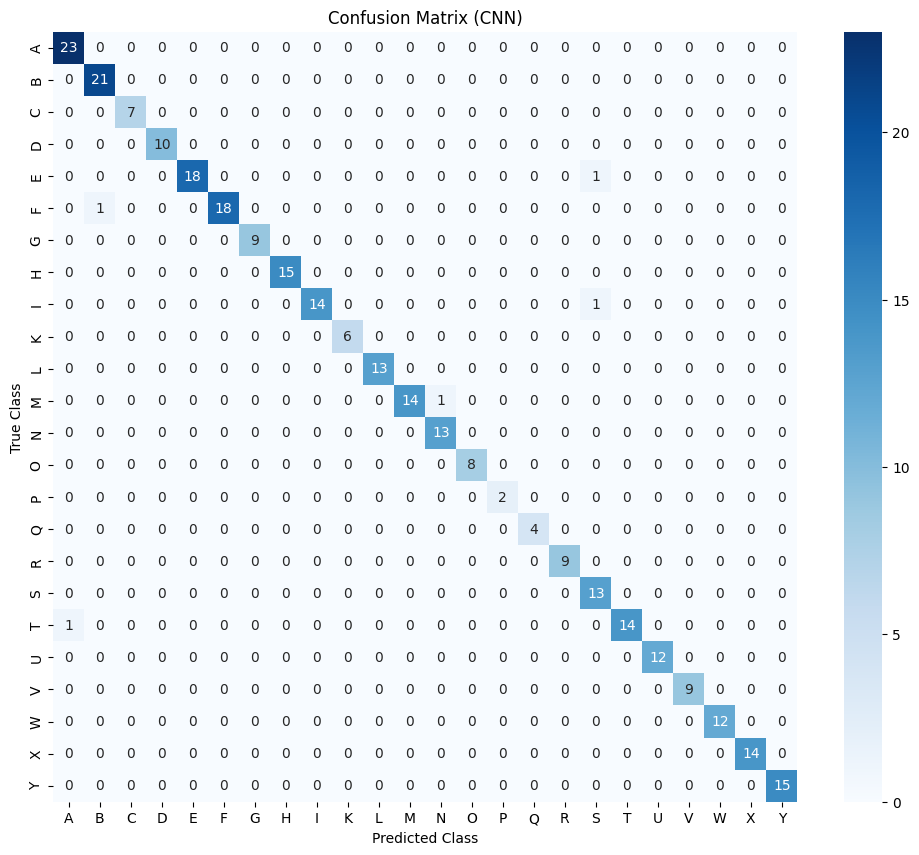

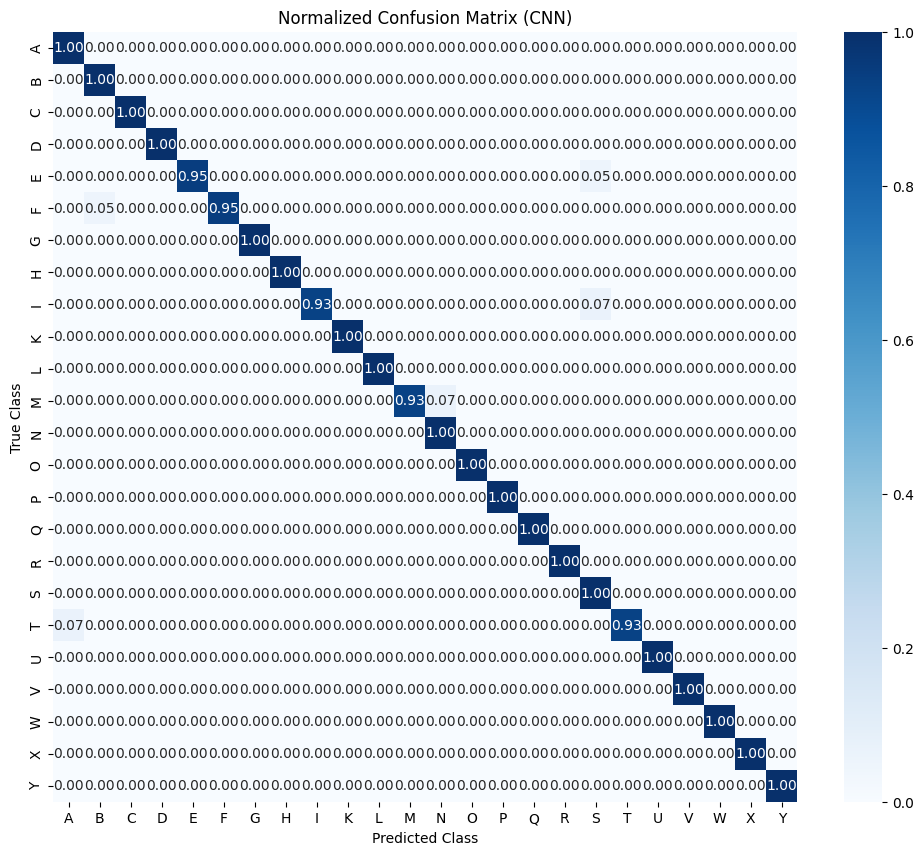

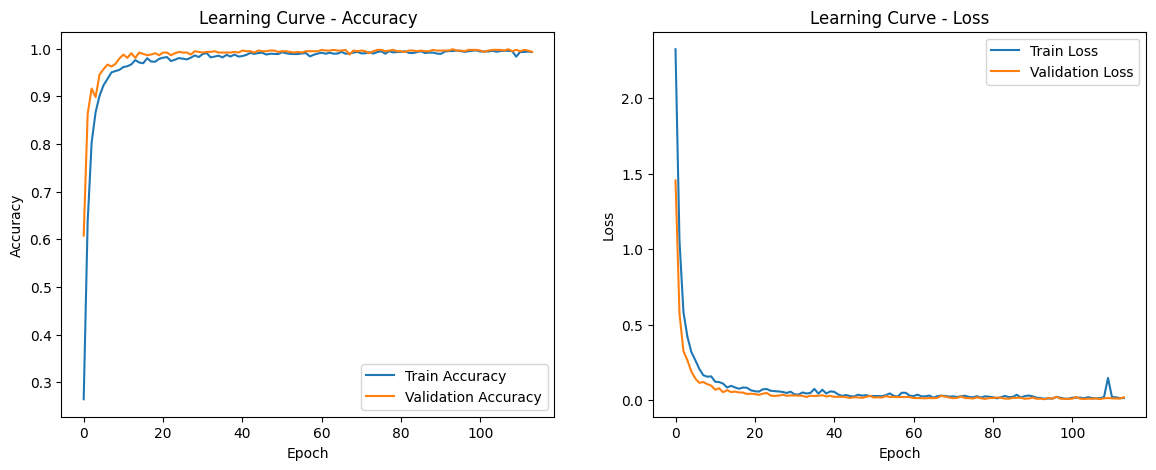


START 10-Fold CROSS VALIDATION (CNN 1D)
Fold 1 Validation Accuracy: 0.9972
Fold 2 Validation Accuracy: 0.9972
Fold 3 Validation Accuracy: 0.9972
Fold 4 Validation Accuracy: 0.9972
Fold 5 Validation Accuracy: 1.0000
Fold 6 Validation Accuracy: 0.9944
Fold 7 Validation Accuracy: 1.0000
Fold 8 Validation Accuracy: 1.0000
Fold 9 Validation Accuracy: 0.9916
Fold 10 Validation Accuracy: 1.0000
10-Fold CV Accuracy (CNN): 0.9975 ± 0.0026
10/10 [==============================] - 0s 3ms/step


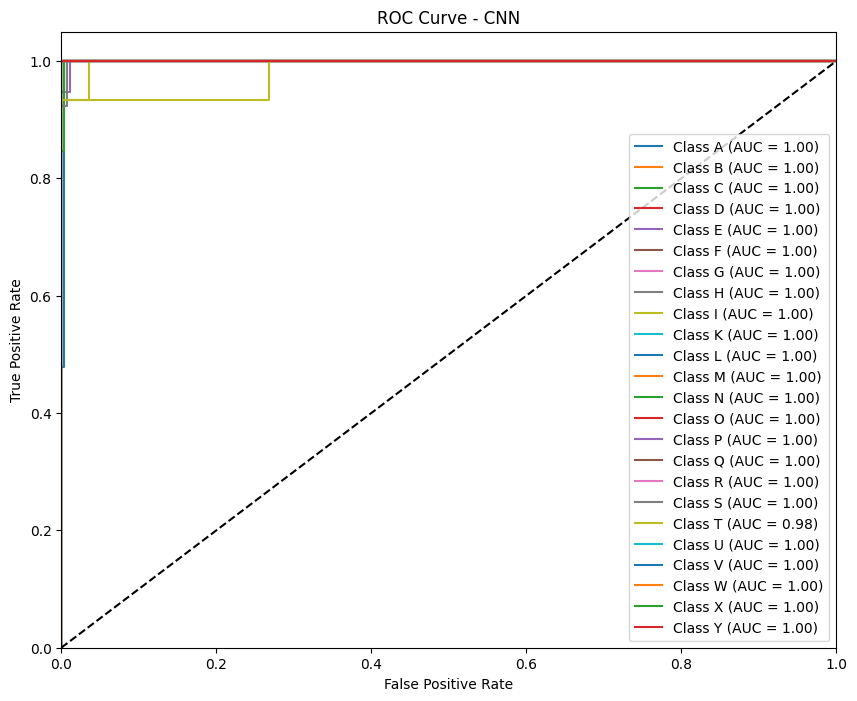

In [14]:
from tensorflow.keras.models import Sequential  # type: ignore
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout  # type: ignore
from tensorflow.keras.callbacks import EarlyStopping  # type: ignore
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time


# =========================
# 1. DEFINE CNN 1D MODEL
# =========================
cnn = Sequential(name="CNN_Model")
cnn.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(63,1), name="Conv1D_64"))
cnn.add(MaxPooling1D(pool_size=2, name="MaxPool_1"))
cnn.add(Dropout(0.3, name="Dropout_1"))

cnn.add(Conv1D(128, kernel_size=3, activation='relu', name="Conv1D_128"))
cnn.add(MaxPooling1D(pool_size=2, name="MaxPool_2"))
cnn.add(Dropout(0.3, name="Dropout_2"))

cnn.add(Flatten(name="Flatten"))
cnn.add(Dense(256, activation='relu', name="Dense_256"))
cnn.add(Dropout(0.3, name="Dropout_3"))
cnn.add(Dense(num_classes, activation='softmax', name="Output"))

cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nCNN 1D MODEL SUMMARY")
cnn.summary()


# =========================
# 2. PREPARE DATA CNN
# =========================
X_train_cnn = X_train[..., np.newaxis]
X_test_cnn  = X_test[..., np.newaxis]


# =========================
# 3. CALLBACK EARLY STOPPING
# =========================
early_stop_cnn = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# =========================
# 4. TRAINING MODEL
# =========================
print("\nSTART TRAINING & EVALUATION")
start_time = time.time()

history_cnn = cnn.fit(
    X_train_cnn,
    y_train_cat,
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop_cnn],
    verbose=1
)

# =========================
# 4. TRAINING TIME
# =========================
end_time = time.time()
print(f"\n Training time: {end_time - start_time:.2f} seconds")

# 5. PREDIKSI DATA UJI
y_test_prob_cnn = cnn.predict(X_test_cnn)
y_test_pred_cnn = np.argmax(y_test_prob_cnn, axis=1)
y_test_true_cnn = np.argmax(y_test_cat, axis=1)

# ==========================================
# 6. ACCURACY, PRECISION, RECALL, F1
# ==========================================
test_acc = accuracy_score(y_test_true_cnn, y_test_pred_cnn)
precision = precision_score(y_test_true_cnn, y_test_pred_cnn, average='weighted')
recall = recall_score(y_test_true_cnn, y_test_pred_cnn, average='weighted')
f1 = f1_score(y_test_true_cnn, y_test_pred_cnn, average='weighted')

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall:    {recall:.4f}")
print(f"Weighted F1-Score:  {f1:.4f}")

print("\nClassification Report:")
print(classification_report(
    y_test_true_cnn,
    y_test_pred_cnn,
    target_names=le.classes_,
    digits=4
))

# =========================
# 7. CONFUSION MATRIX
# =========================
cm = confusion_matrix(y_test_true_cnn, y_test_pred_cnn)
class_labels = le.classes_.tolist()

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix (CNN)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12,10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Normalized Confusion Matrix (CNN)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# =========================
# 8. LEARNING CURVE
# =========================
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title("Learning Curve - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title("Learning Curve - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# =================================
# 9. K-FOLD CROSS VALIDATION
# =================================
print("\nSTART 10-Fold CROSS VALIDATION (CNN 1D)")

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
y_labels = np.argmax(y_train_cat, axis=1)
cv_accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_cnn, y_labels), 1):
    X_train_fold, X_val_fold = X_train_cnn[train_idx], X_train_cnn[val_idx]
    y_train_fold, y_val_fold = y_train_cat[train_idx], y_train_cat[val_idx]

    model_fold = Sequential.from_config(cnn.get_config())
    model_fold.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model_fold.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=100,
        batch_size=32,
        verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

    val_loss, val_acc = model_fold.evaluate(X_val_fold, y_val_fold, verbose=0)
    cv_accuracies.append(val_acc)
    print(f"Fold {fold} Validation Accuracy: {val_acc:.4f}")

mean_cv_acc_cnn = np.mean(cv_accuracies)
std_cv_acc_cnn  = np.std(cv_accuracies)
print(f"10-Fold CV Accuracy (CNN): {mean_cv_acc_cnn:.4f} ± {std_cv_acc_cnn:.4f}")


# =========================
# 10. AUC & ROC
# =========================
from sklearn.metrics import roc_auc_score, roc_curve, auc

y_test_prob_cnn = cnn.predict(X_test_cnn)
fpr, tpr, roc_auc = {}, {}, {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_test_prob_cnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CNN')
plt.legend(loc='lower right')
plt.show()


# Ringkasan Kinerja Model MLP vs CNN


Perbandingan Kinerja MLP vs CNN 1D
        Accuracy  Precision  Recall  F1-Score  10-Fold CV Accuracy
MLP       0.9832     0.9846  0.9832    0.9833               0.9972
CNN 1D    0.9832     0.9846  0.9832    0.9833               0.9975


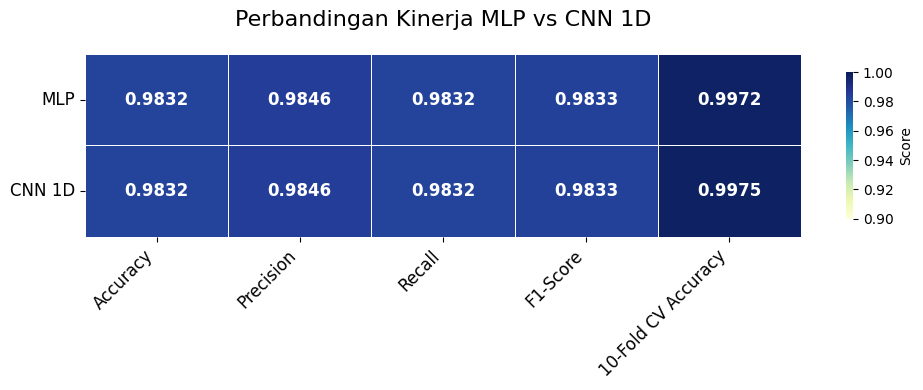


Waktu Inferensi Rata-rata per Sampel:
• MLP    : 0.351 ms
• CNN 1D : 0.317 ms


In [15]:
# =========================
# RINGKASAN KINERJA MLP vs CNN 1D
# =========================
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# MLP
start = time.time()
_ = mlp.predict(X_test, verbose=0)
mlp_time = (time.time() - start) / len(X_test) * 1000  # ms/sample

# CNN 1D
start = time.time()
_ = cnn.predict(X_test_cnn, verbose=0)
cnn_time = (time.time() - start) / len(X_test_cnn) * 1000  # ms/sample

# =========================
# METRIK EVALUASI
# =========================
results = {
    "MLP": {
        "Accuracy": accuracy_score(y_test_true_mlp, y_test_pred_mlp),
        "Precision": precision_score(y_test_true_mlp, y_test_pred_mlp, average="weighted", zero_division=0),
        "Recall": recall_score(y_test_true_mlp, y_test_pred_mlp, average="weighted", zero_division=0),
        "F1-Score": f1_score(y_test_true_mlp, y_test_pred_mlp, average="weighted", zero_division=0),
        "10-Fold CV Accuracy": mean_cv_acc_mlp,
        "Inference Time (ms)": mlp_time
    },
    "CNN 1D": {
        "Accuracy": accuracy_score(y_test_true_cnn, y_test_pred_cnn),
        "Precision": precision_score(y_test_true_cnn, y_test_pred_cnn, average="weighted", zero_division=0),
        "Recall": recall_score(y_test_true_cnn, y_test_pred_cnn, average="weighted", zero_division=0),
        "F1-Score": f1_score(y_test_true_cnn, y_test_pred_cnn, average="weighted", zero_division=0),
        "10-Fold CV Accuracy": mean_cv_acc_cnn,
        "Inference Time (ms)": cnn_time
    }
}

results_df = pd.DataFrame(results).T
metric_cols = ["Accuracy", "Precision", "Recall", "F1-Score", "10-Fold CV Accuracy"]

print("\nPerbandingan Kinerja MLP vs CNN 1D")
print(results_df[metric_cols].round(4))

# =========================
# VISUALISASI HEATMAP
# =========================
plt.figure(figsize=(10, 4))
sns.heatmap(
    results_df[metric_cols].round(4),
    annot=True,
    fmt=".4f",
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "Score", "shrink": 0.8},
    annot_kws={"size": 12, "weight": "bold"},
    vmin=0.90, vmax=1.00
)

plt.title("Perbandingan Kinerja MLP vs CNN 1D", fontsize=16, pad=20)
plt.yticks(rotation=0, fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.tight_layout()
plt.show()

# =========================
# INFERENCE TIME OUTPUT
# =========================
print("\nWaktu Inferensi Rata-rata per Sampel:")
print(f"• MLP    : {mlp_time:.3f} ms")
print(f"• CNN 1D : {cnn_time:.3f} ms")

# =========================
# KESIMPULAN akurasi
# =========================
mlp_acc = results_df.loc["MLP", "Accuracy"]
cnn_acc = results_df.loc["CNN 1D", "Accuracy"]

# Save Model

In [16]:
# =========================
# SIMPAN MODEL
# =========================
mlp.save("best_mlp_sibi.h5")
cnn.save("best_cnn1d_sibi.h5")
print("\nModel berhasil disimpan.")

/media/ekhsan/New Volume/ME/CODE/Landmark_mediapipe/mevenv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Model berhasil disimpan.
